## Homework 3

* Generate dataset using `make_classification` function in the sklearn.datasets class. Generate 10000 samples with 8 features (X) with one label (y). Also, use following parameters    
    * `n_informative` = 5
    *  `class_sep` = 2
    * `random_state` = 42
* Explore and analyse raw data.
* Do preprocessing for classification.
* Split your dataset into train and test test (0.7 for train and 0.3 for test).
* Try Decision Tree and XGBoost Algorithm with different hyperparameters. (Using GridSearchCV is a plus)
* Evaluate your result on both train and test set. Analyse if there is any underfitting or overfitting problem. Make your comments.

In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
import warnings

warnings.filterwarnings("ignore")

In [5]:
# Generate dataset using make_classification function in the sklearn. 
# Convert it into pandas dataframe.

X, y = make_classification(n_samples=1000, n_informative=5,class_sep=2, n_features=8,random_state=42)
df = pd.DataFrame(data=X, columns=[0, 1, 2, 3, 4, 5, 6, 7])
df.head()

,0,1,2,3,4,5,6,7
0,-0.756153,-1.164471,-0.705182,1.108321,-1.078425,0.990766,1.363777,1.727296
1,-0.349763,-0.725064,-0.776536,0.164623,-2.123291,-0.312199,0.081420,1.073886
2,-4.390672,-1.590640,-1.343470,9.286103,2.222753,1.085890,-2.715076,4.223089
3,1.064793,0.967040,-0.723131,-3.114630,0.798928,0.214848,1.890636,-2.379626
4,-0.561940,-1.914989,0.953398,1.090123,-1.048063,-0.600604,1.511169,0.550706


In [8]:
# Check duplicate values and missing data.
print(df.duplicated().sum())
print(df.isna().sum())

0
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64


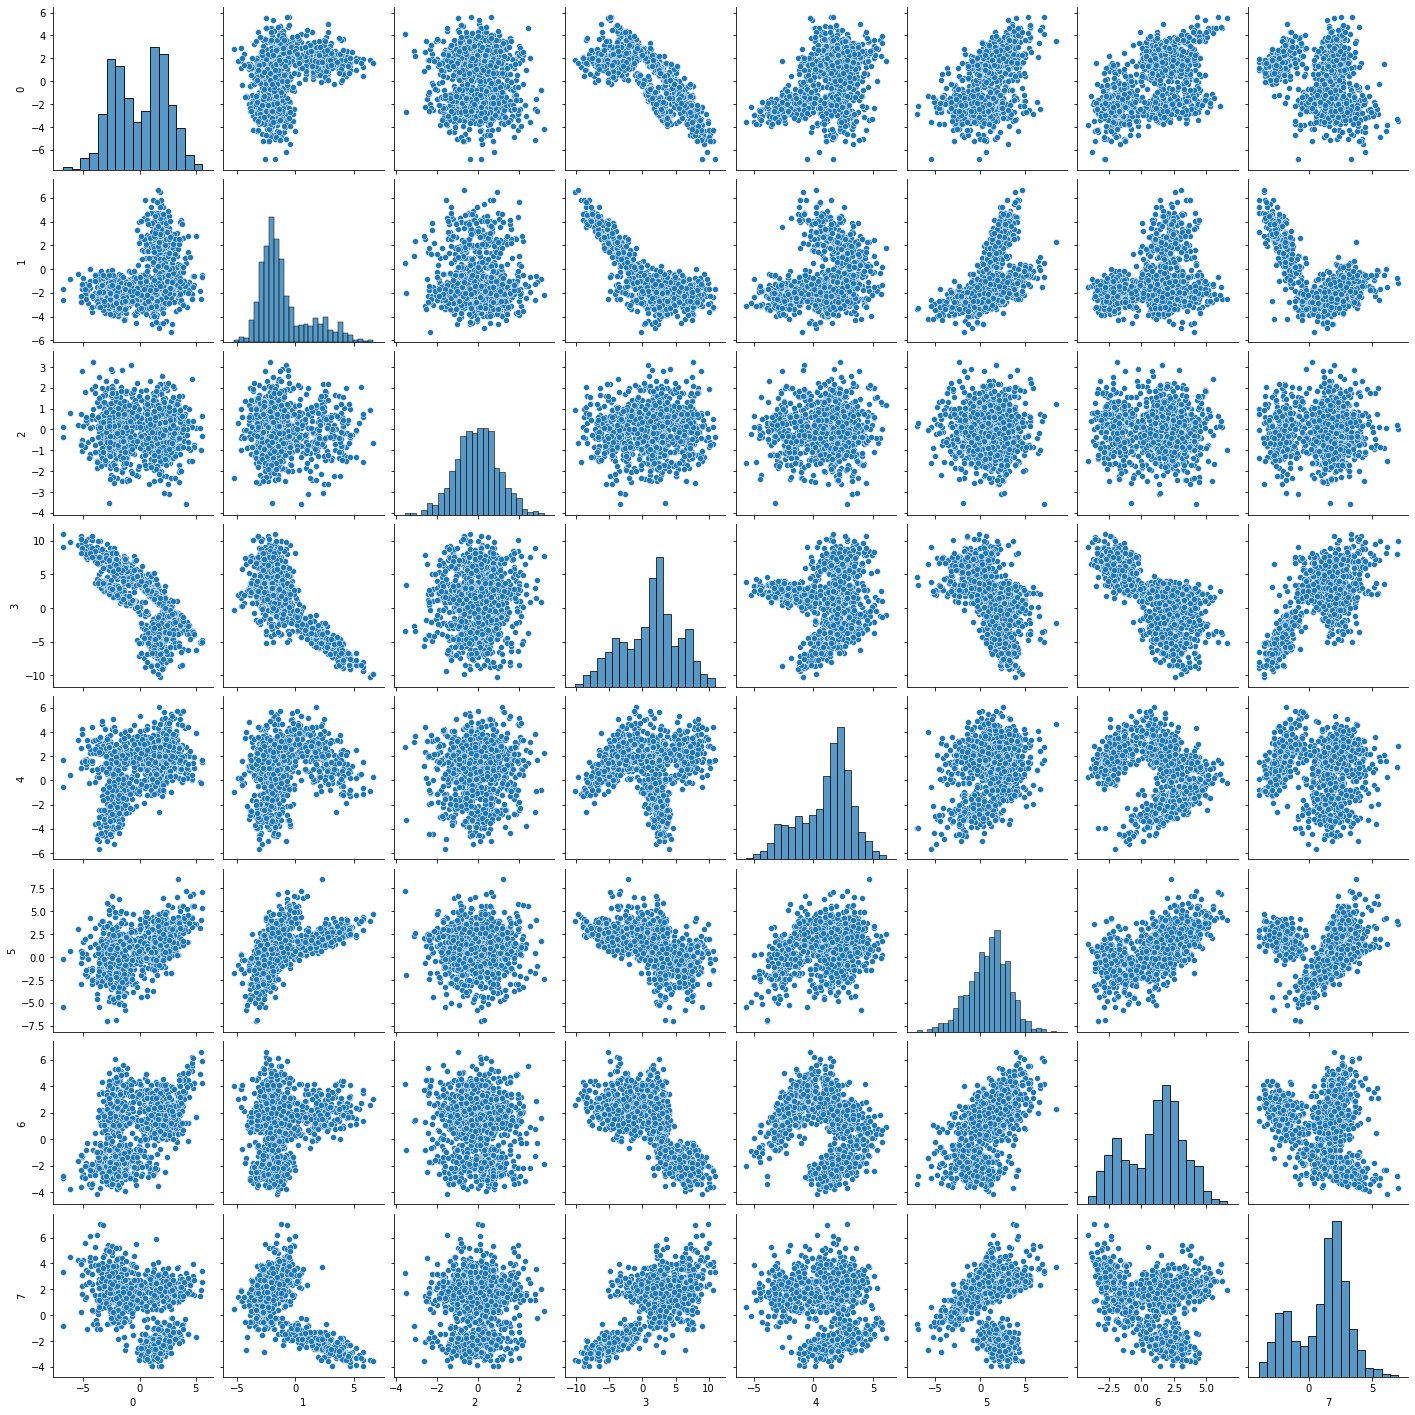

In [10]:
# Visualize data for each feature (pairplot,distplot).
sns.pairplot(df)

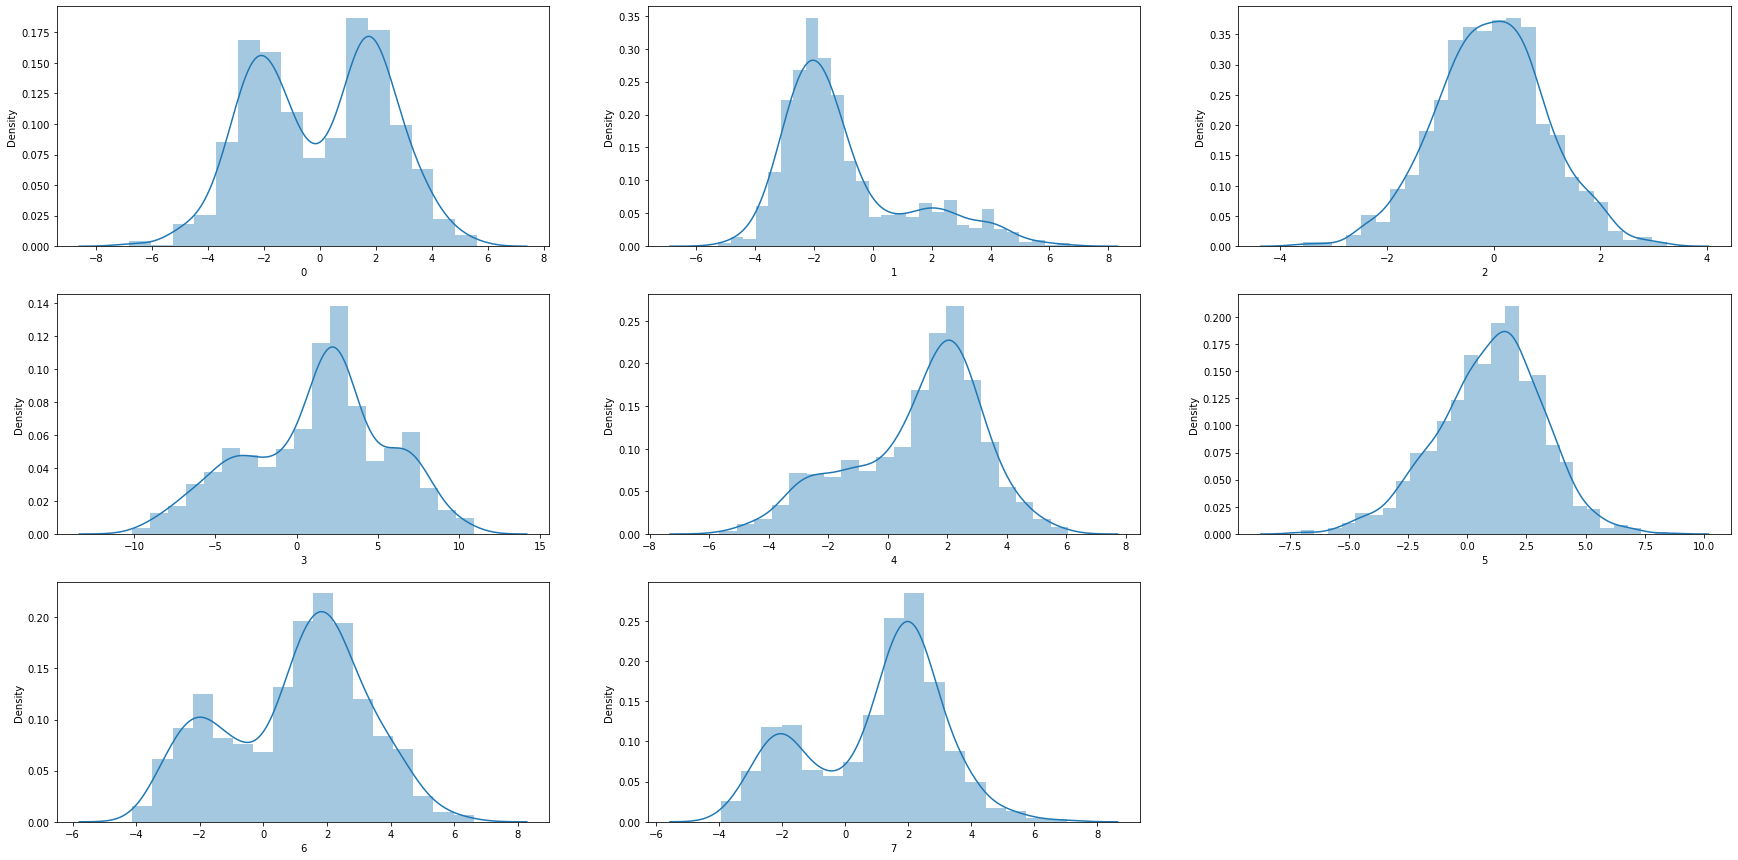

In [13]:
plt.subplots(figsize=(30,15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3,3,i)
    sns.distplot(df[column])

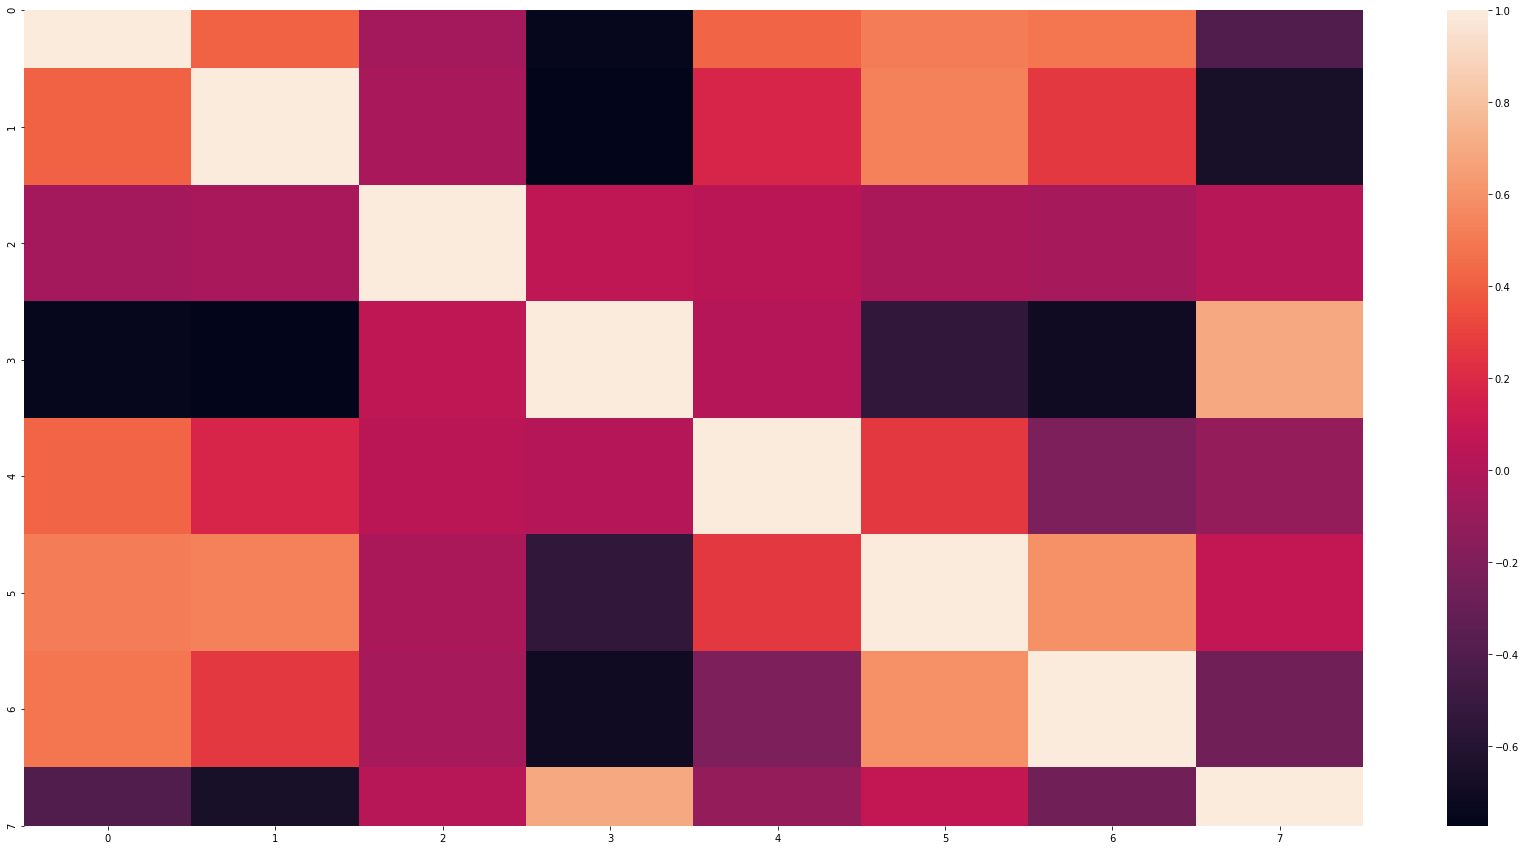

In [14]:
# Draw correlation matrix
plt.subplots(figsize=(30,15))
sns.heatmap(df.corr())

(51, 9)


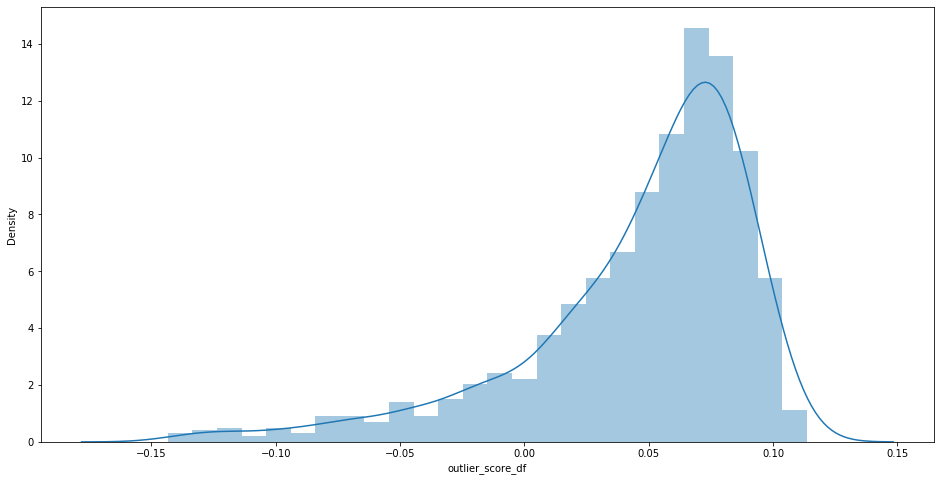

In [21]:
# Handle outliers (you can use IsolationForest, Z-score, IQR)
from sklearn.ensemble import IsolationForest

model=IsolationForest()
model.fit(df)
df['outlier_score_df']=model.decision_function(df)
plt.figure(figsize=(16, 8))
sns.distplot(df["outlier_score_df"])
print(df[df['outlier_score_df']<-0.05].shape)

In [32]:
#Outliers are removed
X_new=df[df['outlier_score_df']>=-0.05]
y_new = y[list(X_new.index)]
del X_new['outlier_score_df']

In [45]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_new_encoded=label_encoder.fit_transform(y_new)

0

In [46]:
print(X_new.shape)
print(len(y_new_encoded))

(949, 8)
949


In [47]:
# Split dataset into train and test set
from sklearn.model_selection import train_test_split, cross_validate
X_train, X_test, y_train, y_test = train_test_split(X_new,y_new_encoded, test_size=0.3, random_state=42)

In [63]:
# Import Decision Tree, define different hyperparamaters and tune the algorithm.

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from scipy.stats import randint

In [66]:
param_dist = {"max_depth": [3, 4, 5, 6, 7],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [67]:
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_cv.fit(X_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 2}
Best score is 0.9563226247436774


In [69]:
tree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 5, max_features= 6, min_samples_leaf= 2)
tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=6,
                       min_samples_leaf=2)

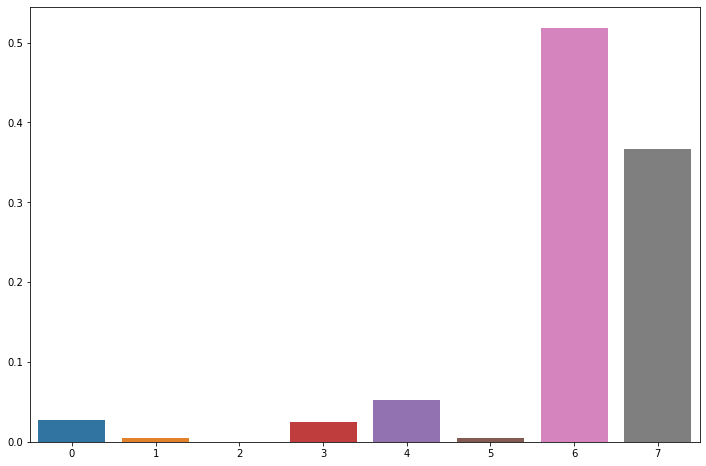

In [70]:
plt.figure(figsize=(12, 8))
importance = tree.feature_importances_
sns.barplot(y=importance, x=X_train.columns)
plt.show()

In [75]:
# Create confusion matrix and calculate accuracy, recall, precision and f1 score.
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, f1_score
pred = tree.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       139
           1       0.96      0.92      0.94       146

    accuracy                           0.94       285
   macro avg       0.94      0.94      0.94       285
weighted avg       0.94      0.94      0.94       285

[[134   5]
 [ 11 135]]


In [80]:
# Import XGBoostClassifier, define different hyperparamters and tune the algorithm.
from xgboost.sklearn import XGBClassifier
param_dict = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'learning_rate': [0.01,0.1,1,2],
    'n_estimators': [10,190,200,210]   
}

In [81]:
xgc = XGBClassifier(booster='gbtree', learning_rate =0.01, n_estimators=200, max_depth=5,num_class=2,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27)

clf = GridSearchCV(xgc,param_dict,cv=3, n_jobs = -1).fit(X_train,y_train)

print("Tuned: {}".format(clf.best_params_)) 
print("Mean of the cv scores is {:.6f}".format(clf.best_score_))
print("Train Score {:.6f}".format(clf.score(X_train,y_train)))
print("Test Score {:.6f}".format(clf.score(X_test,y_test)))
print("Seconds used for refitting the best model on the train dataset: {:.6f}".format(clf.refit_time_))

[00:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Tuned: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 190}
Mean of the cv scores is 0.972885
Train Score 1.000000
Test Score 0.971930
Seconds used for refitting the best model on the train dataset: 0.369013


In [82]:
xgc = XGBClassifier(booster='gbtree', learning_rate =0.1, n_estimators=190, max_depth=3,num_class=2,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27)
xgc.fit(X_train,y_train)

[00:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=190, n_jobs=4, nthread=4, num_class=2,
              num_parallel_tree=1, objective='multi:softprob', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

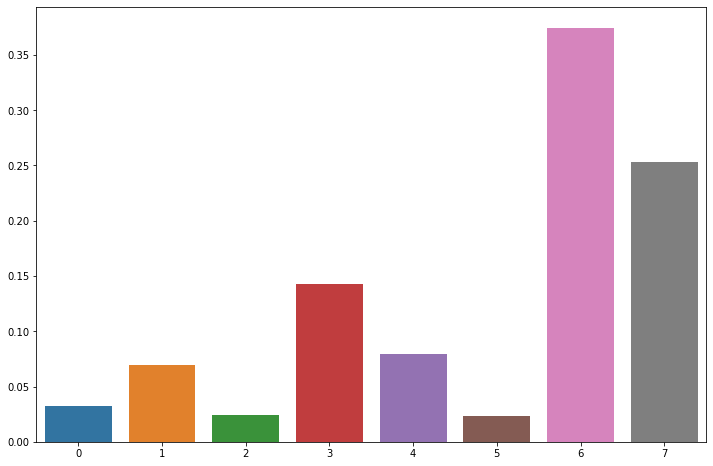

In [83]:
# Visualize feature importances.
plt.figure(figsize=(12, 8))
importance = xgc.feature_importances_
sns.barplot(y=importance, x=X_train.columns)
plt.show()

In [84]:
# Create confusion matrix and calculate accuracy, recall, precision and f1 score.
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, f1_score
pred = xgc.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       139
           1       0.98      0.97      0.97       146

    accuracy                           0.97       285
   macro avg       0.97      0.97      0.97       285
weighted avg       0.97      0.97      0.97       285

[[136   3]
 [  5 141]]


# Evaluate your result and select best performing algorithm for our case.

XGBoost has a better performance